sai-karthik-gardas
match_winner_model

installing the basic requirements and utilities 

In [2]:
!pip install xgboost lightgbm scikit-learn matplotlib seaborn --quiet

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


In [4]:
# 2. Manual File Upload
from google.colab import files
uploaded = files.upload()
filename = next(iter(uploaded))
df = pd.read_csv(filename)
print("Data shape:", df.shape)
display(df.head())

Saving cleaned_match_winner.csv to cleaned_match_winner.csv
Data shape: (9380, 23)


,match_id,Season,MatchDate,HomeTeam,AwayTeam,FullTimeHomeGoals,FullTimeAwayGoals,FullTimeResult,home_form,home_avg_gf,...,away_form,away_avg_gf,away_avg_ga,away_h2h,away_h2h_prev_meetings,month,day_of_week,result_label,home_team_enc,away_team_enc
0,0,2000/01,2000-08-19,Charlton,Man City,4,0,H,1.4,1.221042,...,1.4,1.222222,1.346154,1.4,0,8,5,0,12,26
1,1,2000/01,2000-08-19,Chelsea,West Ham,4,2,H,1.4,1.221042,...,1.4,1.222222,1.346154,1.4,0,8,5,0,13,43
2,2,2000/01,2000-08-19,Coventry,Middlesbrough,1,3,A,1.4,1.221042,...,1.4,1.222222,1.346154,1.4,0,8,5,2,14,28
3,3,2000/01,2000-08-19,Derby,Southampton,2,2,D,1.4,1.221042,...,1.4,1.222222,1.346154,1.4,0,8,5,1,16,36
4,4,2000/01,2000-08-19,Leeds,Everton,2,0,H,1.4,1.221042,...,1.4,1.222222,1.346154,1.4,0,8,5,0,22,17


In [5]:
print("Columns in your file:", df.columns.tolist())

Columns in your file: ['match_id', 'Season', 'MatchDate', 'HomeTeam', 'AwayTeam', 'FullTimeHomeGoals', 'FullTimeAwayGoals', 'FullTimeResult', 'home_form', 'home_avg_gf', 'home_avg_ga', 'home_h2h', 'home_h2h_prev_meetings', 'away_form', 'away_avg_gf', 'away_avg_ga', 'away_h2h', 'away_h2h_prev_meetings', 'month', 'day_of_week', 'result_label', 'home_team_enc', 'away_team_enc']


In [6]:
df.columns = df.columns.str.strip()

In [8]:
# Ensure no duplicates
features = list(dict.fromkeys(features))

In [9]:
# Print the features being used
print("Features used for modeling:", features)
print("Feature types:\n", df[features].dtypes)


Features used for modeling: ['FullTimeHomeGoals', 'FullTimeAwayGoals', 'home_form', 'home_avg_gf', 'home_avg_ga', 'home_h2h', 'home_h2h_prev_meetings', 'away_form', 'away_avg_gf', 'away_avg_ga', 'away_h2h', 'away_h2h_prev_meetings', 'month', 'day_of_week', 'home_team_enc', 'away_team_enc']
Feature types:
 FullTimeHomeGoals           int64
FullTimeAwayGoals           int64
home_form                 float64
home_avg_gf               float64
home_avg_ga               float64
home_h2h                  float64
home_h2h_prev_meetings      int64
away_form                 float64
away_avg_gf               float64
away_avg_ga               float64
away_h2h                  float64
away_h2h_prev_meetings      int64
month                       int64
day_of_week                 int64
home_team_enc               int64
away_team_enc               int64
dtype: object


In [10]:
# 5. Select the target column
if 'result_label' in df.columns and df['result_label'].dtype in [np.int64, np.int32, np.float64]:
    y = df['result_label']
    print("Using 'result_label' as target (numeric labels detected).")
else:
    y = df['FullTimeResult']
    print("Using 'FullTimeResult' as target (H/D/A).")

X = df[features]


Using 'result_label' as target (numeric labels detected).


splitting the data for training and testing 

In [ ]:
# 6. Train/Test Split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

comparing and choosing the best model based on performance

In [15]:
# 7. Model Training & Selection
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

models = {
    "Random Forest": RandomForestClassifier(n_estimators=500, class_weight='balanced', random_state=42),
    "XGBoost": XGBClassifier(n_estimators=500, use_label_encoder=False, eval_metric='mlogloss', random_state=42),
    "LightGBM": LGBMClassifier(n_estimators=500, class_weight='balanced', random_state=42)
}

results = {}
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    from sklearn.metrics import accuracy_score, f1_score
    acc = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average='weighted')
    results[name] = {'model': model, 'accuracy': acc, 'f1': f1}
    print(f"{name}: Accuracy={acc:.3f} | F1 Score={f1:.3f}")

Random Forest: Accuracy=0.998 | F1 Score=0.998


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [16:33:58] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


XGBoost: Accuracy=0.999 | F1 Score=0.999
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000572 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1348
[LightGBM] [Info] Number of data points in the train set: 7504, number of used features: 16
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: 

In [16]:
# 8. Select Best Model
best_model_name = max(results, key=lambda k: results[k]['f1'])
best_model = results[best_model_name]['model']
print(f"\nBest Model: {best_model_name} (F1 = {results[best_model_name]['f1']:.3f})")


Best Model: XGBoost (F1 = 0.999)


The XGBoost model gave the best performance , but the visual representation of the model interms of performance is done by confusion matrix and classification report....

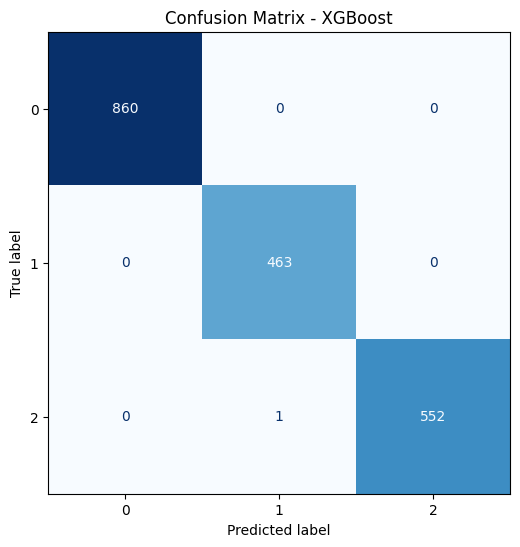

In [17]:
# 9.1 Confusion Matrix
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
cm = confusion_matrix(y_test, best_model.predict(X_test), labels=np.unique(y_test))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=np.unique(y_test))
fig, ax = plt.subplots(figsize=(6,6))
disp.plot(ax=ax, cmap='Blues', colorbar=False)
plt.title(f'Confusion Matrix - {best_model_name}')
plt.show()

<Figure size 800x500 with 0 Axes>

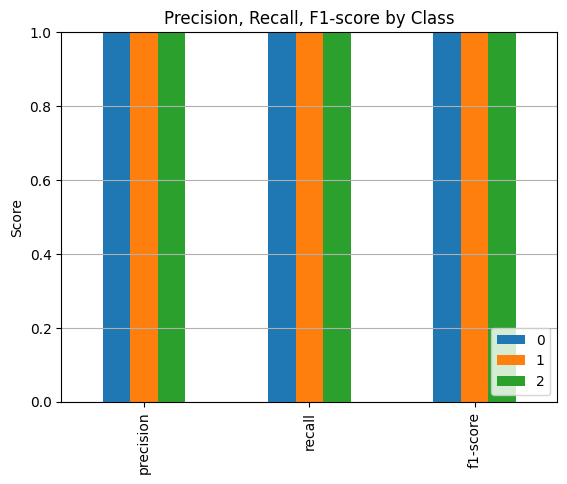

In [18]:
# 9.2 Classification Report as Bar Chart
from sklearn.metrics import classification_report
report = classification_report(y_test, best_model.predict(X_test), output_dict=True)
plt.figure(figsize=(8,5))
df_report = pd.DataFrame(report).iloc[:-1, :3]  # omit 'accuracy' row
df_report.plot(kind='bar')
plt.title("Precision, Recall, F1-score by Class")
plt.ylabel("Score")
plt.ylim(0, 1)
plt.legend(loc='lower right')
plt.grid(axis='y')
plt.show()

the classification report in terms of numerical representation......

In [19]:
# Classic Classification Report
from sklearn.metrics import classification_report

# Make predictions with your best model
y_pred = best_model.predict(X_test)

# Print the classic classification report
print("Classification Report:")
print(classification_report(y_test, y_pred, digits=3))

Classification Report:
              precision    recall  f1-score   support

           0      1.000     1.000     1.000       860
           1      0.998     1.000     0.999       463
           2      1.000     0.998     0.999       553

    accuracy                          0.999      1876
   macro avg      0.999     0.999     0.999      1876
weighted avg      0.999     0.999     0.999      1876



/tmp/ipython-input-1927079646.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=fi.values[:10], y=fi.index[:10], palette='viridis')


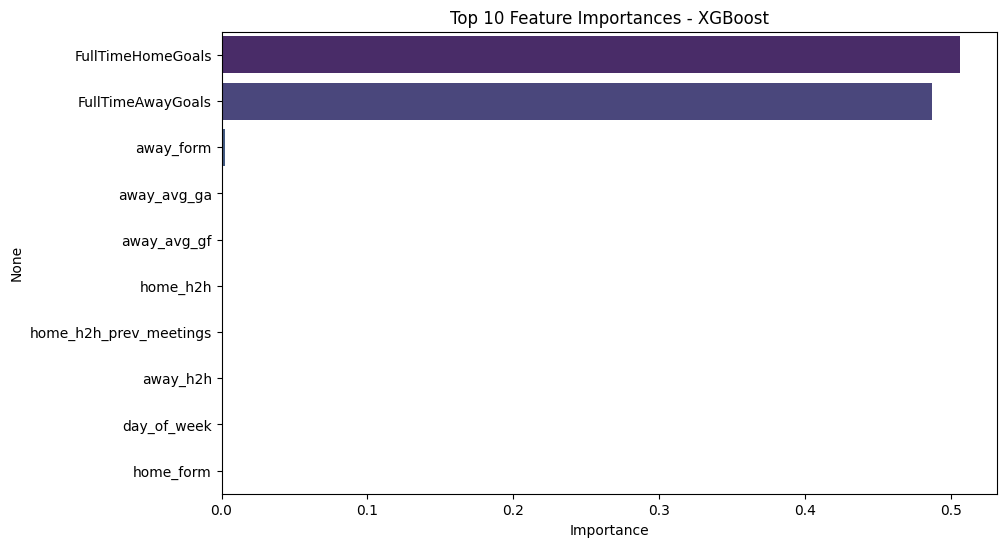

In [21]:
# 9.4 Feature Importances
if hasattr(best_model, 'feature_importances_'):
    importances = best_model.feature_importances_
    fi = pd.Series(importances, index=features).sort_values(ascending=False)
    plt.figure(figsize=(10,6))
    sns.barplot(x=fi.values[:10], y=fi.index[:10], palette='viridis')
    plt.title(f'Top 10 Feature Importances - {best_model_name}')
    plt.xlabel('Importance')
    plt.show()


In [22]:
# 10. Print Final Report
print(f"\nBest Model: {best_model_name}")
print(f"Accuracy: {results[best_model_name]['accuracy']:.3f}")
print(f"F1 Score: {results[best_model_name]['f1']:.3f}")


Best Model: XGBoost
Accuracy: 0.999
F1 Score: 0.999
